<a href="https://colab.research.google.com/github/stawiskm/QSAR_LightGBM/blob/main/Genotoxicity_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ACI Project: QSAR Classification models with RF and LightGBM on Genotoxicity**


---


Marc Jermann   \ Patrick Meier


---

While quantitative structure-activity relationship
models are increasingly used nowadays, this study compares
two different machine learning methods in just such QSAR
models. The Light Gradient Boosting Machine method uses the
well established decision tree approach and has been optimized
for larger datasets. To test the applicability of this method, we
compare it with a Random Forest model, the existing state-of-the-
art method for such QSAR models, in three different applications.


---

In this Jupyter notebook, we will be building a real-life **data science project**. Particularly, we will be building a machine learning model using the data found in [Paper](https://doi.org/10.1016/j.jmgm.2021.108011).

Train: https://ars.els-cdn.com/content/image/1-s2.0-S1093326321001820-mmc8.csv

Test: https://ars.els-cdn.com/content/image/1-s2.0-S1093326321001820-mmc7.csv

Chapter 2, 3, 4 and 5 can be skipped. Preprocessd data downloadable from Github repository.

---



## **1. Import libraries**

First of all, all the required libraries are imported. The most important are Pandas for data handling and Scikit learn and LightGBM for the supervised machine learning models.

In [ ]:
import time
import requests
import ast
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score

## **2. Download the data sets**


Freely available small molecules with their genotoxic properties were retrieved from C. S. M. Chu et al.. We used  their data as the data basis, with a total of 5395 molecules split into two sets.​
The data is downloaded directly from the publisher website.

In [ ]:
url = 'https://ars.els-cdn.com/content/image/1-s2.0-S1093326321001820-mmc8.csv'
# Downloading the file by sending the request to the URL
req = requests.get(url, allow_redirects=True)
# Split URL to get the file name
filename = url.split('/')[-1]

# Writing the file to the local file system
with open(filename, 'wb') as output_file:
    output_file.write(req.content)

df_raw = pd.read_csv("1-s2.0-S1093326321001820-mmc8.csv")

In [ ]:
url = 'https://ars.els-cdn.com/content/image/1-s2.0-S1093326321001820-mmc7.csv'
# Downloading the file by sending the request to the URL
req = requests.get(url, allow_redirects=True)
# Split URL to get the file name
filename = url.split('/')[-1]

# Writing the file to the local file system
with open(filename, 'wb') as output_file:
    output_file.write(req.content)

df_Test_raw = pd.read_csv("1-s2.0-S1093326321001820-mmc7.csv")

In [ ]:
df_raw.columns = ['canonical_smiles', 'class']
df_Test_raw.columns = ['canonical_smiles', 'class']
df_raw['class'] = df_raw['class'].replace({'non-mutagens':'Non-toxic'})
df_raw['class'] = df_raw['class'].replace({'mutagens':'Toxic'})
df_Test_raw['class'] = df_Test_raw['class'].replace({'non-mutagens':'Non-toxic'})
df_Test_raw['class'] = df_Test_raw['class'].replace({'mutagens':'Toxic'})

In [ ]:
def cleanSMILES(row):
    cpd = str(row.canonical_smiles).split('.')
    cpd_longest = max(cpd, key = len)
    return cpd_longest

In [ ]:
df_raw['smiles'] = df_raw.apply(cleanSMILES ,axis=1)
df_Test_raw['smiles'] = df_Test_raw.apply(cleanSMILES ,axis=1)

In [ ]:
df_raw = df_raw.drop("canonical_smiles",axis=1)
df_raw = df_raw.rename({"smiles":"canonical_smiles"},axis=1)
df_Test_raw = df_Test_raw.drop("canonical_smiles",axis=1)
df_Test_raw = df_Test_raw.rename({"smiles":"canonical_smiles"},axis=1)

## **3. Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **3.1 Lipinski Import special libraries**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-06-08 10:36:34--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   154MB/s    in 0.5s    

2022-06-08 10:36:35 (154 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **3.2 Calculate descriptors**

"MW","LogP","NumHDonors","NumHAcceptors"

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(row):

    elem = row.canonical_smiles
    mol=Chem.MolFromSmiles(elem)           
       
    desc_MolWt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Lipinski.NumHDonors(mol)
    desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
    lip = [desc_MolWt,
           desc_MolLogP,
           desc_NumHDonors,
           desc_NumHAcceptors]   
           
    return lip

In [ ]:
df_lip = df_raw[["class","canonical_smiles"]]

In [ ]:
df_lip[["MW","LogP","NumHDonors","NumHAcceptors"]]   = df_lip.apply(lipinski,axis=1, result_type ='expand')

In [ ]:
df_lip.to_csv('QSAR_train_lipinskidata.csv', index=False)

---

## **4. Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **4.1 Define seaborn style**

In [ ]:
sns.set(style='ticks')

### **4.2 Frequency plot of the 2 bioactivity classes**

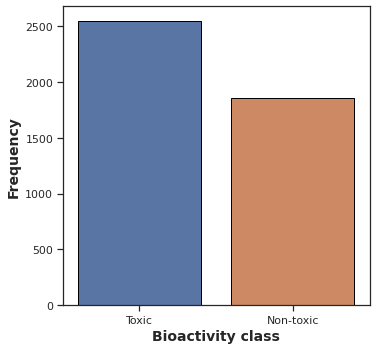

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_lip, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.png', dpi=300, format='png', bbox_inches='tight')

### **4.3 Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

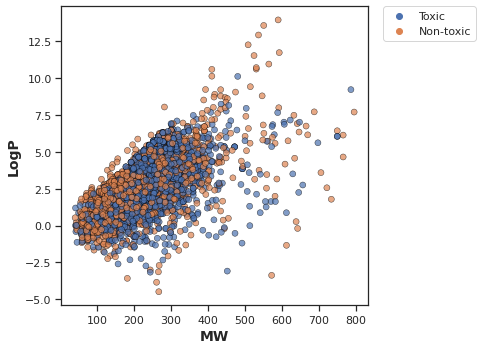

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_lip, hue='class', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.png', dpi=300, format='png', bbox_inches='tight')

### **4.4 Box plots**

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_lip[selection]
  active = df[df['class'] == 'Toxic']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_lip[selection]
  inactive = df[df['class'] == 'Non-toxic']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

#### **MW**

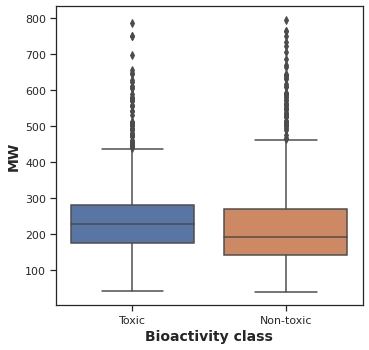

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_lip)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.png', dpi=300, format='png', bbox_inches='tight')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1936458.5,8.622802e-25,0.05,Different distribution (reject H0)


#### **LogP**

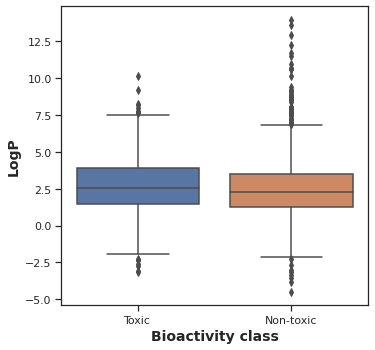

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_lip)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.png', dpi=300, format='png', bbox_inches='tight')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2152423.0,2.506375e-07,0.05,Different distribution (reject H0)


#### **NumHDonors**

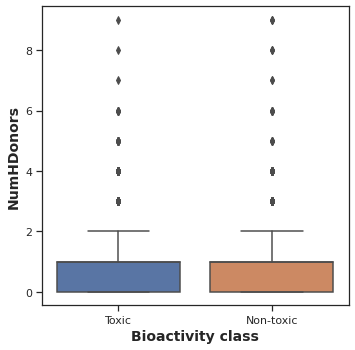

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_lip)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.png', dpi=300, format='png', bbox_inches='tight')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2347936.0,0.361374,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

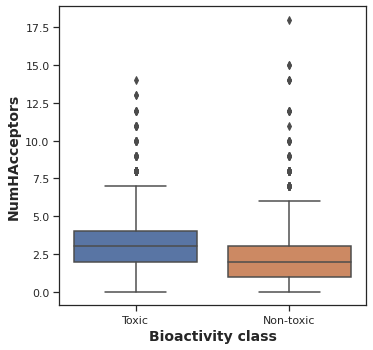

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_lip)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.png', dpi=300, format='png', bbox_inches='tight')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1925666.0,1.184661e-26,0.05,Different distribution (reject H0)


## **5. Feature encoding with PaDEL-Descriptor**

### **5.1 Download PaDEL-Descriptor**

The feature encoding of a symbolic representation of a molecule encoded chemical information into a useful number or the result of a standardized experiment, can be achieved using the open-source software PaDEL-Descriptor, which is downloaded from a Github repository.

The PaDEL-descriptor tool which is built in Java, can be executed in the colab notebook as well via a bash shell command. This is done separately for train and test set.

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-06-08 10:37:43--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2022-06-08 10:37:43--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.09s   

2022-06-08 10:37:43 (278 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2022-06-08 10:37:43--  https://github

In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

### **5.2 Calculate Fingerprint and descriptors Traindata**

In [ ]:
df_raw[["canonical_smiles","class"]].to_csv('molecule.smi', sep='\t', index=False, header=False)
! bash padel.sh
df = pd.read_csv('descriptors_output.csv')
df = df.rename({'Name': 'class'}, axis='columns')
df.to_csv('QSAR_DescriptorData_train.csv', index=False)

Processing Toxic in molecule.smi (1/4402). 
Processing Toxic in molecule.smi (2/4402). 
Processing Toxic in molecule.smi (3/4402). Average speed: 2.87 s/mol.
Processing Toxic in molecule.smi (4/4402). Average speed: 2.87 s/mol.
Processing Toxic in molecule.smi (5/4402). Average speed: 1.00 s/mol.
Processing Non-toxic in molecule.smi (6/4402). Average speed: 0.76 s/mol.
Processing Toxic in molecule.smi (7/4402). Average speed: 0.64 s/mol.
Processing Toxic in molecule.smi (8/4402). Average speed: 0.54 s/mol.
Processing Toxic in molecule.smi (9/4402). Average speed: 0.48 s/mol.
Processing Toxic in molecule.smi (10/4402). Average speed: 0.67 s/mol.
Processing Toxic in molecule.smi (11/4402). Average speed: 0.53 s/mol.
Processing Toxic in molecule.smi (12/4402). Average speed: 0.57 s/mol.
Processing Toxic in molecule.smi (13/4402). Average speed: 0.52 s/mol.
Processing Toxic in molecule.smi (14/4402). Average speed: 0.51 s/mol.
Processing Non-toxic in molecule.smi (15/4402). Average speed: 

### **5.3 Calculate Fingerprint and descriptors Testdata**

In [ ]:
df_Test_raw[["canonical_smiles","class"]].to_csv('molecule.smi', sep='\t', index=False, header=False)
! bash padel.sh
df_Test = pd.read_csv('descriptors_output.csv')
df_Test = df_Test.rename({'Name': 'class'}, axis='columns')
df_Test.to_csv('QSAR_DescriptorData_test.csv', index=False)

Processing Toxic in molecule.smi (1/993). 
Processing Toxic in molecule.smi (2/993). 
Processing Toxic in molecule.smi (4/993). Average speed: 2.10 s/mol.
Processing Non-toxic in molecule.smi (3/993). Average speed: 2.09 s/mol.
Processing Toxic in molecule.smi (5/993). Average speed: 0.74 s/mol.
Processing Toxic in molecule.smi (6/993). Average speed: 0.68 s/mol.
Processing Toxic in molecule.smi (7/993). Average speed: 0.77 s/mol.
Processing Non-toxic in molecule.smi (8/993). Average speed: 1.00 s/mol.
Processing Toxic in molecule.smi (9/993). Average speed: 0.95 s/mol.
Processing Toxic in molecule.smi (10/993). Average speed: 0.86 s/mol.
Processing Toxic in molecule.smi (11/993). Average speed: 0.82 s/mol.
Processing Non-toxic in molecule.smi (12/993). Average speed: 0.82 s/mol.
Processing Toxic in molecule.smi (13/993). Average speed: 0.77 s/mol.
Processing Toxic in molecule.smi (14/993). Average speed: 0.71 s/mol.
Processing Toxic in molecule.smi (15/993). Average speed: 0.75 s/mol.

## **6. Data handling**

In the data handling chapter, the data is converted into the data formats required for machine learning.

In [ ]:
df = pd.read_csv("https://github.com/stawiskm/QSAR_LightGBM/raw/main/data/QSAR_Genotox_DescriptorData_train.csv")
df_Test = pd.read_csv("https://github.com/stawiskm/QSAR_LightGBM/raw/main/data/QSAR_Genotox_DescriptorData_test.csv")

The ***genotoxicity*** data set contains 881 input features and 1 output variable (class values).

In [ ]:
df.sample(5)

,class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
2623,Toxic,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3514,Toxic,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2786,Toxic,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,Toxic,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891,Non-toxic,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Train DATA shape:",df.shape)
print("TEST DATA shape:",df_Test.shape)

Train DATA shape: (4402, 882)
TEST DATA shape: (993, 882)


In [ ]:
X_train = df.drop('class', axis=1)
X_test = df_Test.drop('class', axis=1)

In [ ]:
y_train = df["class"]
y_test = df_Test["class"]

In [ ]:
X_train.sample(3)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1729,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3421,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3672,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train.sample(3)

2833    Toxic
2043    Toxic
1868    Toxic
Name: class, dtype: object

## **7. Building a Classification Model using Random Forest Classifier**

### **7.1 Random Forest Internal validation**

Then the classification models are built, starting with the well-established Random Forest. 
First, the scoring is defined, which is used for all subsequent cross validations. Then, a stratified 5 fold cross-validation of a Random Forest model with optimized parameters is performed and the results of this internal validation are stored in a table.

In [ ]:
# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc",
           "Accuracy": make_scorer(accuracy_score),
           "Precision":make_scorer(precision_score, average="binary", pos_label='Toxic'),
           "Recall":make_scorer(recall_score, average="binary", pos_label='Toxic')}

In [ ]:
rf = RandomForestClassifier(random_state=42)

parameters = {'max_depth': [40],
              'min_samples_leaf': [1],
              'min_samples_split': [5],
              'n_estimators': [800]
              }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

clf = GridSearchCV(rf, parameters,cv=cv,verbose=2,n_jobs=-1,scoring=scoring,refit="Accuracy",return_train_score=True)

startTime = time.time()

#Model search
clf.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Execution time in seconds: 62.97924757003784


In [ ]:
parameterlist = []
for parameter in list(parameters.keys()):
  feature = "param_"+parameter
  parameterlist.append(feature)
print(parameterlist)

['param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators']


In [ ]:
def defineSet(row):
    return str(row.variable).split("_")[1]
def defineMetric(row):
    return str(row.variable).split("_")[2]

In [ ]:
dfGridsearch = pd.DataFrame(clf.cv_results_)
droplist = ['mean_fit_time', 'std_fit_time',
            'mean_score_time', 'std_score_time',
            'mean_test_Accuracy','mean_test_Precision','mean_test_Recall',
            'mean_train_Accuracy','mean_train_Precision','mean_train_Recall',
            'std_test_Accuracy','std_test_Precision','std_test_Recall',
            'std_train_Accuracy','std_train_Precision','std_train_Recall',
            'rank_test_Accuracy','rank_test_Precision','rank_test_Recall',
            'mean_test_AUC','mean_train_AUC','std_test_AUC','std_train_AUC','rank_test_AUC'
            ]+parameterlist
dfScoreResults = dfGridsearch.drop(droplist,axis=1)
dfScoreResults = pd.melt(dfScoreResults, id_vars=['params'])
dfScoreResults["set"] = dfScoreResults.apply(defineSet, axis=1)
dfScoreResults["metric"] = dfScoreResults.apply(defineMetric, axis=1)
dfScoreResults = dfScoreResults.drop(["variable"],axis=1)
dfScoreResults["params"]=dfScoreResults["params"].astype(str)

In [ ]:
# for comparison
dfScoreRFresult = dfScoreResults
dfScoreRFresult["model"] = "RF_model_1" 
dfScoreRFresult["method"] = "Random Forest" 

### **7.2 Random Forest External validation**

This optimized Random Forest model is now trained again with the entire training set and the time needed to train the model is recorded. Finally, the test set is predicted for external validation and the scores of the various metrics are recorded in a table. 

In [ ]:
ModelResultsTable = pd.DataFrame()

In [ ]:
print(clf.best_params_)
model =  RandomForestClassifier(max_depth=clf.best_params_["max_depth"],
                                min_samples_leaf=clf.best_params_["min_samples_leaf"],
                                min_samples_split=clf.best_params_["min_samples_split"],
                                n_estimators=clf.best_params_["n_estimators"],
                                random_state=42)


startTime = time.time()

#Model training
model.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
#Accuracy / Precission / Recall / ROC auc
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="binary", pos_label='Toxic')
rec = recall_score(y_test, y_pred, average="binary", pos_label='Toxic')
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
output = pd.DataFrame({"Model":"RF_model_1","Accuracy":acc,"Precision":pre,"Recall":rec,"ROC_AUC":roc_auc,"Params":[clf.best_params_],"ExecutionTime":executionTime})
ModelResultsTable = pd.concat([output, ModelResultsTable], ignore_index=True)
ModelResultsTable

{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}
Execution time in seconds: 13.079042434692383


,Model,Accuracy,Precision,Recall,ROC_AUC,Params,ExecutionTime
0,RF_model_1,0.778449,0.810268,0.728916,0.839183,"{'max_depth': 40, 'min_samples_leaf': 1, 'min_...",13.079042


## **8. Building a Classification Model using LGBMClassifier**

### **8.1 LightGBM Internal validation**

The next step is to create various LightGBM models using a gridsearch, combining previously defined parameters in all possible ways to create 48 different models. These models undergo the same stratified 5 fold cross validations with the same metrics as Random Forest models before. These results are also stored in a table for internal validation.

In [ ]:
lgbm = LGBMClassifier(random_state=42)

parameters = {"boosting_type":["gbdt","dart"],
              "learning_rate":[0.063,0.126],
              "n_estimators" :[6,24,96],
              "num_leaves" : [32,64],
              "subsample_for_bin":[60000],
              'max_depth': [21,42]
              }
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

clf = GridSearchCV(lgbm, parameters,cv=cv,verbose=2,n_jobs=-1,scoring=scoring,refit="Accuracy",return_train_score=True)

startTime = time.time()

#Model search
clf.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Execution time in seconds: 182.42139983177185


In [ ]:
parameterlist = []
for parameter in list(parameters.keys()):
  feature = "param_"+parameter
  parameterlist.append(feature)
print(parameterlist)

['param_boosting_type', 'param_learning_rate', 'param_n_estimators', 'param_num_leaves', 'param_subsample_for_bin', 'param_max_depth']


In [ ]:
def defineModelName(df):
    name = "LGBM_model_"
    count = 1
    modelNames = []
    oldParam=[None]
    for param in df.params:
        if param not in oldParam:
            count = count + 1
            oldParam.append(param)
        modelNames.append(name+str(oldParam.index(param)))
    return modelNames

In [ ]:
dfGridsearch = pd.DataFrame(clf.cv_results_)
droplist = ['mean_fit_time', 'std_fit_time',
            'mean_score_time', 'std_score_time',
            'mean_test_Accuracy','mean_test_Precision','mean_test_Recall',
            'mean_train_Accuracy','mean_train_Precision','mean_train_Recall',
            'std_test_Accuracy','std_test_Precision','std_test_Recall',
            'std_train_Accuracy','std_train_Precision','std_train_Recall',
            'rank_test_Accuracy','rank_test_Precision','rank_test_Recall',
            'mean_test_AUC','mean_train_AUC','std_test_AUC','std_train_AUC','rank_test_AUC'
            ]+parameterlist
dfScoreResults = dfGridsearch.drop(droplist,axis=1)
dfScoreResults = pd.melt(dfScoreResults, id_vars=['params'])
dfScoreResults["set"] = dfScoreResults.apply(defineSet, axis=1)
dfScoreResults["metric"] = dfScoreResults.apply(defineMetric, axis=1)
dfScoreResults = dfScoreResults.drop(["variable"],axis=1)
dfScoreResults["params"]=dfScoreResults["params"].astype(str)
dfScoreResults["method"]= "LightGBM"
dfScoreResults["model"] = defineModelName(dfScoreResults)
dfScoreResults = pd.concat([dfScoreResults,dfScoreRFresult],axis=0)

In [ ]:
modelsParamsDict = dfScoreResults[["model","params"]].set_index('model').drop_duplicates().to_dict('index')

### **8.2 LightGBM External validation**

As with the Random Forest Model, the best four LightGBM models, the models that achieved the highest average accuracy values during the internal validation, are now trained again for the external validation and evaluated with the test set. 

LGBM_model_12

LGBM_model_6  

LGBM_model_23

LGBM_model_17

In [ ]:
clfmodel = ast.literal_eval(modelsParamsDict["LGBM_model_12"]["params"])
print(clfmodel)
model =  LGBMClassifier(boosting_type=clfmodel["boosting_type"],
                        learning_rate=clfmodel['learning_rate'],
                        n_estimators=clfmodel['n_estimators'],
                        num_leaves=clfmodel['num_leaves'],
                        subsample_for_bin=clfmodel["subsample_for_bin"],
                        max_depth=clfmodel["max_depth"],
                        random_state=42)
startTime = time.time()

#Model training
model.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

#Accuracy / Precission / Recall 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="binary", pos_label='Toxic')
rec = recall_score(y_test, y_pred, average="binary", pos_label='Toxic')
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

output = pd.DataFrame({"Model":"LGBM_model_12","Accuracy":acc,"Precision":pre,"Recall":rec,"ROC_AUC":roc_auc,"Params":[clfmodel],"ExecutionTime":executionTime})
ModelResultsTable = pd.concat([output, ModelResultsTable], ignore_index=True)

{'boosting_type': 'gbdt', 'learning_rate': 0.063, 'max_depth': 42, 'n_estimators': 96, 'num_leaves': 64, 'subsample_for_bin': 60000}
Execution time in seconds: 1.5933418273925781


In [ ]:
clfmodel = ast.literal_eval(modelsParamsDict["LGBM_model_6"]["params"])
print(clfmodel)
model =  LGBMClassifier(boosting_type=clfmodel["boosting_type"],
                        learning_rate=clfmodel['learning_rate'],
                        n_estimators=clfmodel['n_estimators'],
                        num_leaves=clfmodel['num_leaves'],
                        subsample_for_bin=clfmodel["subsample_for_bin"],
                        max_depth=clfmodel["max_depth"],
                        random_state=42)
startTime = time.time()

#Model training
model.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

#Accuracy / Precission / Recall 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="binary", pos_label='Toxic')
rec = recall_score(y_test, y_pred, average="binary", pos_label='Toxic')
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

output = pd.DataFrame({"Model":"LGBM_model_6","Accuracy":acc,"Precision":pre,"Recall":rec,"ROC_AUC":roc_auc,"Params":[clfmodel],"ExecutionTime":executionTime})
ModelResultsTable = pd.concat([output, ModelResultsTable], ignore_index=True)

{'boosting_type': 'gbdt', 'learning_rate': 0.063, 'max_depth': 21, 'n_estimators': 96, 'num_leaves': 64, 'subsample_for_bin': 60000}
Execution time in seconds: 1.4767181873321533


In [ ]:
clfmodel = ast.literal_eval(modelsParamsDict["LGBM_model_23"]["params"])
print(clfmodel)
model =  LGBMClassifier(boosting_type=clfmodel["boosting_type"],
                        learning_rate=clfmodel['learning_rate'],
                        n_estimators=clfmodel['n_estimators'],
                        num_leaves=clfmodel['num_leaves'],
                        subsample_for_bin=clfmodel["subsample_for_bin"],
                        max_depth=clfmodel["max_depth"],
                        random_state=42)
startTime = time.time()

#Model training
model.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

#Accuracy / Precission / Recall 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="binary", pos_label='Toxic')
rec = recall_score(y_test, y_pred, average="binary", pos_label='Toxic')
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

output = pd.DataFrame({"Model":"LGBM_model_23","Accuracy":acc,"Precision":pre,"Recall":rec,"ROC_AUC":roc_auc,"Params":[clfmodel],"ExecutionTime":executionTime})
ModelResultsTable = pd.concat([output, ModelResultsTable], ignore_index=True)

{'boosting_type': 'gbdt', 'learning_rate': 0.126, 'max_depth': 42, 'n_estimators': 96, 'num_leaves': 32, 'subsample_for_bin': 60000}
Execution time in seconds: 1.0486576557159424


In [ ]:
clfmodel = ast.literal_eval(modelsParamsDict["LGBM_model_17"]["params"])
print(clfmodel)
model =  LGBMClassifier(boosting_type=clfmodel["boosting_type"],
                        learning_rate=clfmodel['learning_rate'],
                        n_estimators=clfmodel['n_estimators'],
                        num_leaves=clfmodel['num_leaves'],
                        subsample_for_bin=clfmodel["subsample_for_bin"],
                        max_depth=clfmodel["max_depth"],
                        random_state=42)

startTime = time.time()

#Model training
model.fit(X_train, y_train)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

#Accuracy / Precission / Recall 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="binary", pos_label='Toxic')
rec = recall_score(y_test, y_pred, average="binary", pos_label='Toxic')
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

output = pd.DataFrame({"Model":"LGBM_model_17","Accuracy":acc,"Precision":pre,"Recall":rec,"ROC_AUC":roc_auc,"Params":[clfmodel],"ExecutionTime":executionTime})
ModelResultsTable = pd.concat([output, ModelResultsTable], ignore_index=True)

{'boosting_type': 'gbdt', 'learning_rate': 0.126, 'max_depth': 21, 'n_estimators': 96, 'num_leaves': 32, 'subsample_for_bin': 60000}
Execution time in seconds: 1.0409886837005615


## **9. Results**

The two datasets from C. S. M. Chu et al. were used as the data basis, comprising a total of 5395 molecules in SMILES form and their genotoxic properties split into two sets, a training set of 4402 molecules and a test set of 993 molecules. From these molecules, 881 substructure fingerprints were calculated to characterize the structure of the compound and to use as features for the next step of screening.

A total of 48 different LightGBM QSAR models were created. All created models achieved a good performance during the five-fold cross-validation with respect to accuracy 0.801 ± 0.024. The best LightGBM model showed an accuracy of 0.827± 0.016. The additionally created reference Random Forest model achieved an accuracy of 0.825 ± 0.026 during the five-fold cross-validation, which is only marginally worse compared to the LightGBM. Also the other two metrics Precision and Recall over the LightGBM models show only minor differences to the Random Forest model.

In the external validation with the test data set, the best LightGBM model showed a performance of accuracy 0.774, precision 0.798 and recall 0.737. The reference RF model showed a performance of accuracy 0.778, precision 0.810 and recall 0.729, which is only in accuracy and precision marginally better compared to the LightGBM. But there is a clear difference in the time needed to train a model, the Random Forest needed about 10 seconds whereas the LightGBM models needed only about 1 second.



### **9.1 Random Forest Internal validation**

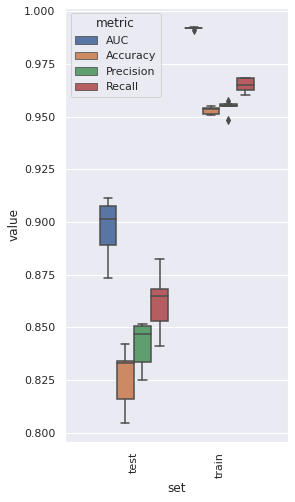

In [ ]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(4,8)})
ax = sns.boxplot(x="set", y="value", hue="metric", data=dfScoreResults[dfScoreResults["method"]=="Random Forest"])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.plot()
plt.savefig('result_RF_TrainVsTest.png', dpi=300, format='png', bbox_inches='tight')

### **9.2 LightGBM Internal validation**

In [ ]:
print("\n Mean of Accuracy:\n",dfScoreResults[(dfScoreResults["metric"]=="Accuracy")&(dfScoreResults["set"]=="test")].groupby(["method"]).mean())
print("\n Std of Accuracy:\n",dfScoreResults[(dfScoreResults["metric"]=="Accuracy")&(dfScoreResults["set"]=="test")].groupby(["method"]).std())


 Mean of Accuracy:
                   value
method                 
LightGBM       0.802545
Random Forest  0.825989

 Std of Accuracy:
                   value
method                 
LightGBM       0.024988
Random Forest  0.015246


In [ ]:
print("\n Mean of Precision:\n",dfScoreResults[(dfScoreResults["metric"]=="Precision")&(dfScoreResults["set"]=="test")].groupby(["method"]).mean())
print("\n Std of Precision:\n",dfScoreResults[(dfScoreResults["metric"]=="Precision")&(dfScoreResults["set"]=="test")].groupby(["method"]).std())


 Mean of Precision:
                   value
method                 
LightGBM       0.806941
Random Forest  0.841418

 Std of Precision:
                   value
method                 
LightGBM       0.034124
Random Forest  0.011698


In [ ]:
print("\n Mean of Recall:\n",dfScoreResults[(dfScoreResults["metric"]=="Recall")&(dfScoreResults["set"]=="test")].groupby(["method"]).mean())
print("\n Std of Recall:\n",dfScoreResults[(dfScoreResults["metric"]=="Recall")&(dfScoreResults["set"]=="test")].groupby(["method"]).std())


 Mean of Recall:
                   value
method                 
LightGBM       0.869535
Random Forest  0.861909

 Std of Recall:
                   value
method                 
LightGBM       0.024034
Random Forest  0.015635


In [ ]:
dfScoreResultsByParams = dfScoreResults[(dfScoreResults["metric"]=="Accuracy")&(dfScoreResults["set"]=="test")].groupby(["model"]).mean()
dfScoreResultsByParams = dfScoreResultsByParams.sort_values('value', ascending = False)
dfScoreResultsByParamsSubset = dfScoreResultsByParams[dfScoreResultsByParams.value > 0.8259]
print("\nMean Accuracy of best models:\n",dfScoreResultsByParamsSubset)
bestModels = list(dfScoreResultsByParamsSubset.index)
print("\n\nmodels showing best accuracy in internal validation: \n",bestModels)
dfScoreResultsByParamsSTD = dfScoreResults[(dfScoreResults["metric"]=="Accuracy")&(dfScoreResults["set"]=="test")].groupby(["model"]).std()
dfScoreResultsByParamsSTDSubset = dfScoreResultsByParamsSTD[dfScoreResultsByParams.value > 0.8259]
print("\n Std Accuracy of best models:\n",dfScoreResultsByParamsSTDSubset)


Mean Accuracy of best models:
                   value
model                  
LGBM_model_12  0.829174
LGBM_model_6   0.827128
LGBM_model_23  0.826220
LGBM_model_17  0.825993
RF_model_1     0.825989


models showing best accuracy in internal validation: 
 ['LGBM_model_12', 'LGBM_model_6', 'LGBM_model_23', 'LGBM_model_17', 'RF_model_1']

 Std Accuracy of best models:
                   value
model                  
LGBM_model_12  0.020204
LGBM_model_17  0.019751
LGBM_model_23  0.019612
LGBM_model_6   0.019421
RF_model_1     0.015246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


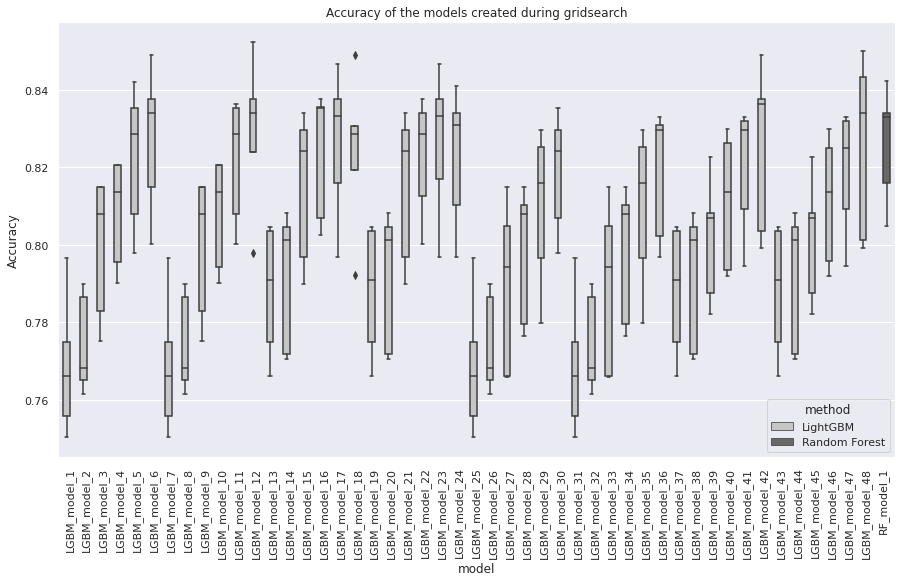

In [ ]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="model", y="value",hue="method", data=dfScoreResults[(dfScoreResults["metric"]=="Accuracy")&(dfScoreResults["set"]=="test")],palette="Greys")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set(title='Accuracy of the models created during gridsearch')
ax.set_ylabel("Accuracy")
plt.plot()
plt.savefig('result_Acc_RF-Vs-LGBM.png', dpi=300, format='png', bbox_inches='tight')

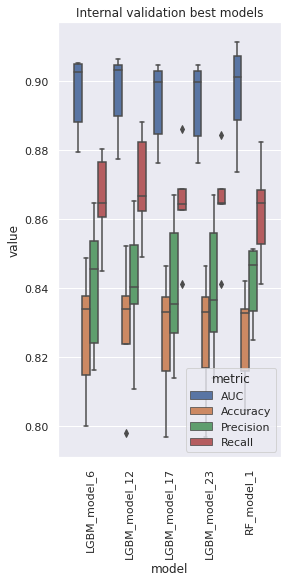

In [ ]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(4,8)})
ax = sns.boxplot(x="model", y="value", hue="metric", data=dfScoreResults[(dfScoreResults["model"].isin(bestModels))&(dfScoreResults["set"]=="test")])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set(title='Internal validation best models')
plt.plot()
plt.savefig('result_Acc_RF-Vs-BestLGBM.png', dpi=300, format='png', bbox_inches='tight')

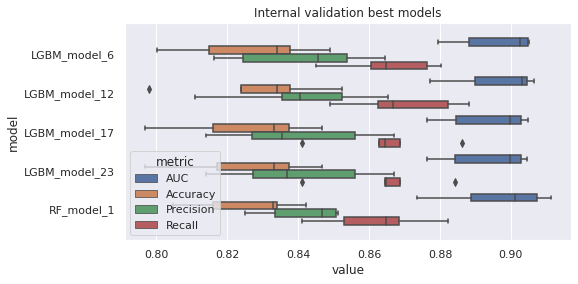

In [ ]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(8,4)})
ax = sns.boxplot(x="value", y="model", hue="metric", data=dfScoreResults[(dfScoreResults["model"].isin(bestModels))&(dfScoreResults["set"]=="test")])
ax.set(title='Internal validation best models')
plt.plot()
plt.savefig('result_Acc_RF-Vs-BestLGBM2.png', dpi=300, format='png', bbox_inches='tight')

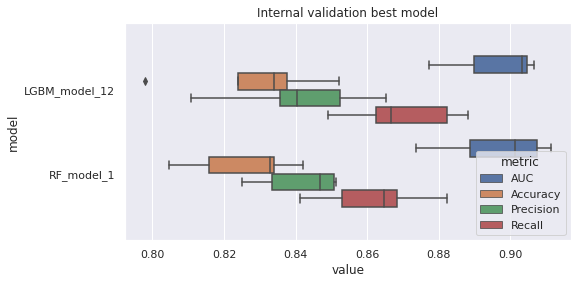

In [ ]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(8,4)})
ax = sns.boxplot(x="value", y="model", hue="metric", data=dfScoreResults[(dfScoreResults["model"].isin(["RF_model_1","LGBM_model_12"]))&(dfScoreResults["set"]=="test")])
ax.set(title='Internal validation best model')
plt.plot()
plt.savefig('result_Acc_RF-Vs-BestLGBM3.png', dpi=300, format='png', bbox_inches='tight')

### **9.3 External validation**

In [ ]:
ModelResultsTable.to_csv('genotox-Results.csv', index=False)

In [ ]:
ModelResultsTable

,Model,Accuracy,Precision,Recall,ROC_AUC,Params,ExecutionTime
0,LGBM_model_17,0.774421,0.797826,0.736948,0.836433,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",1.040989
1,LGBM_model_23,0.774421,0.797826,0.736948,0.836433,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",1.048658
2,LGBM_model_6,0.771400,0.792657,0.736948,0.835183,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",1.476718
3,LGBM_model_12,0.765358,0.777778,0.744980,0.835828,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",1.593342
4,RF_model_1,0.778449,0.810268,0.728916,0.839183,"{'max_depth': 40, 'min_samples_leaf': 1, 'min_...",13.079042


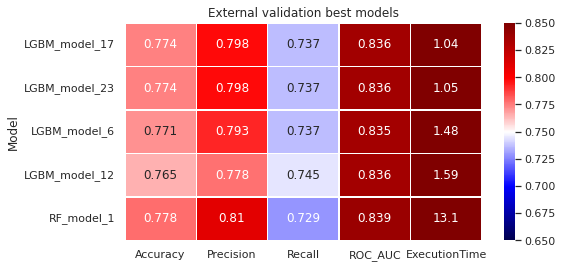

In [ ]:
resultsTable = ModelResultsTable.drop(["Params"],axis=1)
resultsTable = resultsTable.set_index('Model')
sns.set(rc = {'figure.figsize':(8,4)})
ax = sns.heatmap(resultsTable, annot=True, fmt='.3g',linewidths=.5, cmap="seismic",vmin=.65,vmax=.85)
ax.set(title='External validation best models')
plt.savefig('result_RF-Vs-BestLGBM2.png', dpi=300, format='png', bbox_inches='tight')

## **10. Conclusions**
The LightGBM is slowly finding its way into practical use and may replace the RF as the most popular classifier. Our study shows that the emerging LightGBM also has potential in QSAR model and can deliver equally good results as the popular Random Forest. Both methods delivered comparable accuracy, recall and precision scores, in the internal and external validation, predicting the genotoxicity of small molecules.



### **Zip files**

In [68]:
! zip -r genotox_results.zip . -i *.csv *.png

updating: mannwhitneyu_NumHDonors.csv (deflated 9%)
updating: genotox-Results.csv (deflated 63%)
updating: mannwhitneyu_LogP.csv (deflated 9%)
updating: QSAR_DescriptorData_test.csv (deflated 96%)
updating: descriptors_output.csv (deflated 96%)
updating: QSAR_DescriptorData_train.csv (deflated 96%)
updating: QSAR_train_lipinskidata.csv (deflated 76%)
updating: mannwhitneyu_MW.csv (deflated 9%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 12%)
updating: 1-s2.0-S1093326321001820-mmc8.csv (deflated 83%)
updating: 1-s2.0-S1093326321001820-mmc7.csv (deflated 75%)
  adding: plot_NumHAcceptors.png (deflated 19%)
  adding: result_RF_TrainVsTest.png (deflated 20%)
  adding: plot_bioactivity_class.png (deflated 26%)
  adding: result_Acc_RF-Vs-BestLGBM.png (deflated 18%)
  adding: plot_MW_vs_LogP.png (deflated 2%)
  adding: result_Acc_RF-Vs-LGBM.png (deflated 31%)
  adding: plot_LogP.png (deflated 22%)
  adding: result_RF-Vs-BestLGBM2.png (deflated 9%)
  adding: result_Acc_RF-Vs-BestLGBM3.p